# Basic Convolutional Auto-encoder


In [200]:
import os
import cv2
import numpy as np
import imutils
from sklearn.metrics import classification_report

import collections
from collections import namedtuple, OrderedDict

import typing
from typing import List, Tuple, Union

import matplotlib
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchsummary import summary

from torch import nn
from torch.nn import (Sequential,
                      Module,
                      Conv2d,
                      ConvTranspose2d,
                      Upsample,
                      Linear,
                      MaxPool2d,
                      ReLU,
                      Flatten,
                      Unflatten,
                      LogSoftmax)

import torchvision.datasets
from torchvision.datasets import KMNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Subset
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cpu


## Model Definition

In [261]:
class AutoEncoderBase(Sequential):
    def __init__(self, *args, **kwargs):
        super(AutoEncoderBase, self).__init__(*args, **kwargs)
    def get_k_out_shape(self,
                        in_shape: Tuple[int,int,int], 
                        module: Union[Conv2d, MaxPool2d] = None, 
                        kernel: Union[Tuple[int,int], int] = None,
                        stride: Union[Tuple[int,int], int] = None,
                        padding: Union[Tuple[int,int], int] = None,
                        out_channels: int = None,
                        ) -> Tuple[int,int,int]:
        # validate arguments.
        if isinstance(module, (Conv2d, MaxPool2d)):
            kernel = module.kernel_size
            stride = module.stride
            padding = module.padding
            if isinstance(module, Conv2d): out_channels = module.out_channels
        elif not all([isinstance(kernel, (tuple, int)), 
                    isinstance(stride, (tuple, int)), 
                    isinstance(padding, (tuple, int))]):
            raise ValueError("Arguments kernel, stride and padding must be ints or tuples of ints.")
        # split into x,y axises.
        if isinstance(kernel, int): kernel_y, kernel_x = kernel, kernel
        else: kernel_y, kernel_x = kernel
        if isinstance(stride, int): stride_y, stride_x = stride, stride
        else: stride_y, stride_x = stride
        if isinstance(padding, int): padding_y, padding_x = padding, padding
        else: padding_y, padding_x = padding
        # calculate dimensions.
        h = int( np.ceil( (in_shape[1] + (padding_y*2) - (kernel_y-1) ) / stride_y ) )
        w = int( np.ceil( (in_shape[2] + (padding_x*2) - (kernel_x-1) ) / stride_x ) )
        if out_channels is None: out_channels = in_shape[0]
        return out_channels, h, w
    def init_x_shapes(self, 
                      image_shape: Tuple[int,int,int], 
                      init_channels: int, 
                      layer_depth: int, 
                      kernel_size: Union[Tuple[int,int], int],
                      stride: Union[Tuple[int,int], int],
                      padding: Union[Tuple[int,int], int],
                      fully_connected: bool,
                      latent_dim: int):
        # determine all shapes throughout feeding forward.
        x_shapes: List[Tuple[int,int,int]] = [image_shape, [init_channels,-1.-1]]
        for _ in range(layer_depth):
            x_shapes[-1] = self.get_k_out_shape(in_shape=x_shapes[-2], 
                                                 kernel=kernel_size, 
                                                 stride=stride, 
                                                 padding=padding, 
                                                 out_channels=x_shapes[-1][0])
            x_shapes.append([x_shapes[-1][0], x_shapes[-1][1]//2, x_shapes[-1][2]//2])
            x_shapes.append([x_shapes[-1][0]*2,-1,-1])
        x_shapes.pop()
        if fully_connected: x_shapes += [(np.prod(x_shapes[-1]),), (latent_dim,)]
        self._x_shapes = x_shapes
    @property
    def x_shapes(self) -> list: return self._x_shapes

In [262]:
class ConvLayer(Sequential):
    def __init__(self, 
                 conv_in_channels: int, 
                 conv_out_channels: int, 
                 conv_kernel_size: Tuple[int,int] = (5,5),
                 conv_stride: int = 1,
                 conv_padding: int = 0,    
                 pool_kernel_size: Tuple[int,int] = (2,2),
                 pool_stride: int = (2,2),
                 pool_padding: int = 0,
                 acitvation_func: Module = ReLU,
                 ) -> None:
        super(ConvLayer, self).__init__(
            Conv2d(in_channels=conv_in_channels, 
                   out_channels=conv_out_channels, 
                   kernel_size=conv_kernel_size, 
                   stride=conv_stride, 
                   padding=conv_padding), 
            acitvation_func(), 
            MaxPool2d(kernel_size=pool_kernel_size, 
                      stride=pool_stride, 
                      padding=pool_padding)
            )

In [263]:
class Encoder(AutoEncoderBase):
    def __init__(self, 
                image_shape: Tuple[int,int,int], 
                layer_depth: int,
                latent_dim: int, 
                init_channels: int = 32,
                conv_kernel_size: Tuple[int,int] = (5,5),
                conv_stride: int = 1,
                conv_padding: int = 0,    
                pool_kernel_size: Tuple[int, int] = (2, 2),
                pool_stride: int = (2, 2),
                pool_padding: int = 0,
                acitvation_func: Module = ReLU,
                fully_connected: bool = True,
                 ) -> None:
        # determine all shapes throughout feeding forward.
        self.init_x_shapes(image_shape=image_shape,
                           init_channels=init_channels,
                           layer_depth=layer_depth,
                           kernel_size=conv_kernel_size,
                           stride=conv_stride,
                           padding=conv_padding,
                           fully_connected=fully_connected,
                           latent_dim=latent_dim)
        # construct each layer.
        encoder_layers: List[ConvLayer] = []
        for i in range(layer_depth):
            idx = i*2
            encoder_layers.append(ConvLayer(
                conv_in_channels=self.x_shapes[idx][0], 
                conv_out_channels=self.x_shapes[idx+1][0],
                conv_kernel_size=conv_kernel_size,
                conv_stride=conv_stride,
                conv_padding=conv_padding,
                pool_kernel_size= pool_kernel_size,
                pool_stride=pool_stride,
                pool_padding=pool_padding,
                acitvation_func=acitvation_func))
        # Fully connceted layer for flattening to latent.
        if fully_connected: encoder_layers += [ Flatten(), Linear(in_features=self.x_shapes[-2][0], out_features=self.x_shapes[-1][0]) ]
        # Sequential.
        super(Encoder, self).__init__(*encoder_layers)

In [265]:
class TConvLayer(Sequential):
    def __init__(self, 
                 upsample_size: Tuple[int,int],
                 tconv_in_channels: int, 
                 tconv_out_channels: int, 
                 tconv_kernel_size: Tuple[int,int] = (5,5),
                 tconv_stride: int = 1,
                 tconv_padding: int = 0,
                 activation_func: Module = ReLU,
                 ) -> None:
        super(TConvLayer, self).__init__(
            Upsample(size=upsample_size),
            ConvTranspose2d(in_channels=tconv_in_channels, 
                            out_channels=tconv_out_channels, 
                            kernel_size=tconv_kernel_size, 
                            stride=tconv_stride, 
                            padding=tconv_padding),
            activation_func(),
            )        

In [266]:
class Decoder(AutoEncoderBase):
    def __init__(self, 
                 image_shape: Tuple[int,int,int], 
                 layer_depth: int,
                 latent_dim: int, 
                 kernel_size: Tuple[int,int] = (5,5),
                 stride: int = 1,
                 padding: int = 0,    
                 init_channels: int = 32,
                 fully_connected: bool = True,
                 ) -> None:
        # determine all shapes throughout feeding forward.
        self.init_x_shapes(image_shape=image_shape,
                           init_channels=init_channels,
                           layer_depth=layer_depth,
                           kernel_size=kernel_size,
                           stride=stride,
                           padding=padding,
                           fully_connected=fully_connected,
                           latent_dim=latent_dim)
        self._x_shapes.reverse()
        # fully connected layer for unflattening from latent.
        decoder_layers = [ Linear(in_features=self.x_shapes[0][0], out_features=self.x_shapes[1][0]), Unflatten(1, self.x_shapes[2]) ]
        # construct each layer
        for i in range(layer_depth):
            idx = (i*2)+3
            decoder_layers.append(TConvLayer(
                upsample_size=self.x_shapes[idx][1:],
                tconv_in_channels=self.x_shapes[idx][0],
                tconv_out_channels=self.x_shapes[idx+1][0],
                tconv_kernel_size=kernel_size,
                tconv_stride=stride,
                tconv_padding=padding,
            ))
        # Sequential.
        super(Decoder, self).__init__(*decoder_layers)
        

In [271]:
class EmptyModule(Module):
    def forward(self, x): return x

In [272]:
image_shape = (1,64,64)
layer_depth = 3
latent_dim = 128
encoder = Encoder(image_shape, layer_depth, latent_dim)
decoder = Decoder(image_shape, layer_depth, latent_dim)
ae_model = Sequential(EmptyModule(), encoder, decoder)
ae_stat = summary(ae_model, image_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       EmptyModule-1            [-1, 1, 64, 64]               0
            Conv2d-2           [-1, 32, 60, 60]             832
              ReLU-3           [-1, 32, 60, 60]               0
         MaxPool2d-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 64, 26, 26]          51,264
              ReLU-6           [-1, 64, 26, 26]               0
         MaxPool2d-7           [-1, 64, 13, 13]               0
            Conv2d-8            [-1, 128, 9, 9]         204,928
              ReLU-9            [-1, 128, 9, 9]               0
        MaxPool2d-10            [-1, 128, 4, 4]               0
          Flatten-11                 [-1, 2048]               0
           Linear-12                  [-1, 128]         262,272
           Linear-13                 [-1, 2048]         264,192
        Unflatten-14            [-1, 12

## Dataset

In [3]:
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
BATCH_SIZE = 64

In [13]:
# load the KMNIST dataset
trainData = KMNIST(root="data", train=True, download=True, transform=ToTensor())
testData = KMNIST(root="data", train=False, download=True, transform=ToTensor())
numTestSamples = int(len(testData))

# calculate the train/validation split
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)
(trainData, valData) = random_split(trainData, [numTrainSamples, numValSamples], generator=torch.Generator().manual_seed(42))

print(f"Training data: {numTrainSamples}, Validation data: {numValSamples}, Test data: {numTestSamples}")

Training data: 45000, Validation data: 15000, Test data: 10000


In [5]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE
print(f"Training steps: {trainSteps}, Validation steps: {valSteps}")

Training steps: 703, Validation steps: 234


## Model Construction

In [6]:
# initialize the LeNet model
model = LeNet(numChannels=1, classes=len(trainData.dataset.classes), imageShape=trainData.dataset[0][0].size()[1:]).to(DEVICE)
inputShape = (1,28,28)
summary(model, inputShape)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 20, 24, 24]          520
├─ReLU: 1-2                              [-1, 20, 24, 24]          --
├─MaxPool2d: 1-3                         [-1, 20, 12, 12]          --
├─Conv2d: 1-4                            [-1, 50, 8, 8]            25,050
├─ReLU: 1-5                              [-1, 50, 8, 8]            --
├─MaxPool2d: 1-6                         [-1, 50, 4, 4]            --
├─Flatten: 1-7                           [-1, 800]                 --
├─Linear: 1-8                            [-1, 500]                 400,500
├─ReLU: 1-9                              [-1, 500]                 --
├─Linear: 1-10                           [-1, 10]                  5,010
├─LogSoftmax: 1-11                       [-1, 10]                  --
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
Total mult-adds (M): 2.29
Input size (MB): 0.00
Forward/backward pass 

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 20, 24, 24]          520
├─ReLU: 1-2                              [-1, 20, 24, 24]          --
├─MaxPool2d: 1-3                         [-1, 20, 12, 12]          --
├─Conv2d: 1-4                            [-1, 50, 8, 8]            25,050
├─ReLU: 1-5                              [-1, 50, 8, 8]            --
├─MaxPool2d: 1-6                         [-1, 50, 4, 4]            --
├─Flatten: 1-7                           [-1, 800]                 --
├─Linear: 1-8                            [-1, 500]                 400,500
├─ReLU: 1-9                              [-1, 500]                 --
├─Linear: 1-10                           [-1, 10]                  5,010
├─LogSoftmax: 1-11                       [-1, 10]                  --
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
Total mult-adds (M): 2.29
Input size (MB): 0.00
Forward/backward pass 

## Inferencing

C:\Users\User\AppData\Local\Temp\ipykernel_16524\4058749131.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


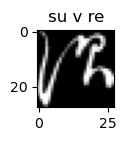

In [7]:
# Load data.
x, y_hat = testData[0]
x = x.to(DEVICE)
label_hat = testData.classes[y_hat]

# Inference.
y = model(x.unsqueeze(0))
y = np.argmax(y.to(torch.device('cpu')).detach().numpy())
label = testData.classes[y]

fig = plt.figure(figsize=(1,1))
axes = fig.subplots(1,1)
axes.imshow(x.permute(1,2,0).to(torch.device('cpu')).detach().numpy(), 'gray')
axes.set_title(f"{label_hat} v {label}")
fig.show()

## Model Training

Choice of loss/cost function should match to the output layer of the network. In this case, we have to determine categorical cross-entropy loss. Since LeNet has LogSoftmax at the output layer then we use nn.NLLoss or negative log-likelihood. If the network has Linear at the output layer then we use nn.CrossEntropyLoss loss.

In [8]:
# define training hyperparameters
INIT_LR = 1e-3
EPOCHS = 10

# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss() # negative log-likelihood


'\nCombine the nn.NLLoss class with LogSoftmax in our model definition, \nwe arrive at categorical cross-entropy loss \n(which is the equivalent to training a model with an output Linear layer and an nn.CrossEntropyLoss loss).\n'

In PyTorch framework, in any training loop, we must compile the exact order:<br>
`opt.zero_grad()`<br>
`loss.backward()`<br>
`opt.step()`<br>
, before do anything else.

In [9]:
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

# loop over our epochs
for e in range(0, EPOCHS):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# initialize the number of correct predictions in the training and validation step
	trainCorrect = 0
	valCorrect = 0
	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)
		# zero out the gradients, perform the backpropagation step, and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
  
	# switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (x, y) in valDataLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += lossFn(pred, y)
			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / numTrainSamples
	valCorrect = valCorrect / numValSamples
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_acc"].append(valCorrect)
	# print the model training and validation information
	print("EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avgValLoss, valCorrect))


EPOCH: 1/10
Train loss: 0.343636, Train accuracy: 0.8936
Val loss: 0.141579, Val accuracy: 0.9589

EPOCH: 2/10
Train loss: 0.094264, Train accuracy: 0.9716
Val loss: 0.100371, Val accuracy: 0.9701

EPOCH: 3/10
Train loss: 0.056518, Train accuracy: 0.9833
Val loss: 0.084031, Val accuracy: 0.9741

EPOCH: 4/10
Train loss: 0.036750, Train accuracy: 0.9887
Val loss: 0.077237, Val accuracy: 0.9781

EPOCH: 5/10
Train loss: 0.024139, Train accuracy: 0.9922
Val loss: 0.078868, Val accuracy: 0.9801

EPOCH: 6/10
Train loss: 0.018458, Train accuracy: 0.9940
Val loss: 0.074754, Val accuracy: 0.9805

EPOCH: 7/10
Train loss: 0.016896, Train accuracy: 0.9944
Val loss: 0.077001, Val accuracy: 0.9817

EPOCH: 8/10
Train loss: 0.013253, Train accuracy: 0.9954
Val loss: 0.081694, Val accuracy: 0.9803

EPOCH: 9/10
Train loss: 0.008580, Train accuracy: 0.9973
Val loss: 0.085885, Val accuracy: 0.9809

EPOCH: 10/10
Train loss: 0.009445, Train accuracy: 0.9972
Val loss: 0.095214, Val accuracy: 0.9799



C:\Users\User\AppData\Local\Temp\ipykernel_4828\647624368.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


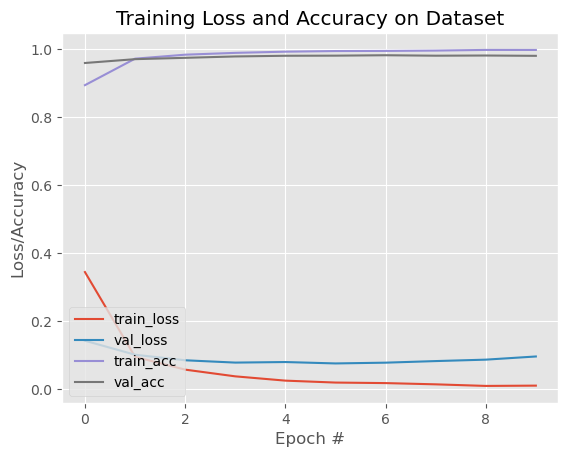

In [14]:
# plot the training loss and accuracy
# matplotlib.use("agg") # choose backend rendering engine.
plt.style.use("ggplot")
fig, axes = plt.subplots(1,1)
axes.plot(H["train_loss"], label="train_loss")
axes.plot(H["val_loss"], label="val_loss")
axes.plot(H["train_acc"], label="train_acc")
axes.plot(H["val_acc"], label="val_acc")
axes.set_title("Training Loss and Accuracy on Dataset")
axes.set_xlabel("Epoch #")
axes.set_ylabel("Loss/Accuracy")
axes.legend(loc="lower left")
fig.show()

# save image file.
history_image_filepath = 'results/KMNIST/history.png'
os.makedirs(os.path.dirname(history_image_filepath), exist_ok=True)
fig.savefig(history_image_filepath)

## Saving Model

Usually we use `torch.save` to save only model states or moodel weights.


In [42]:
# save model file.
model_filepath = 'model-store\KMNIST\LeNet.pt'
os.makedirs(os.path.dirname(model_filepath), exist_ok=True)
torch.save(model, model_filepath)

To save together with model definition, use Just-In-Time or JIT model by `torch.jit.script` or `torch.jit.trace`, which trace model definition/handler, such as forward methods, into intermediate script that is executed during inferencing or runtime (JIT), then `torch.jit.save` to save the JIT model. See https://pytorch.org/docs/stable/jit.html#frequently-asked-questions.

JIT model remembers its original device when it is traced. As soon as you load the JIT model, it will be loaded into the orginal device.

In [158]:
jit_model_filepath = 'model-store/KMNIST/JIT_LeNet.pt'
os.makedirs(os.path.dirname(jit_model_filepath), exist_ok=True)
jit_model = torch.jit.script(model)
torch.jit.save(jit_model, jit_model_filepath)

## Model Evaluation

In [8]:
# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()
	
	# initialize a list to store our predictions
	preds = []
	# loop over the test set
	for (x, y) in testDataLoader:
		# send the input to the device
		x = x.to(DEVICE)
		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
# generate a classification report
print(classification_report(testData.targets.cpu().numpy(), np.array(preds), target_names=testData.classes))

              precision    recall  f1-score   support

           o       0.22      0.11      0.15      1000
          ki       0.08      0.13      0.10      1000
          su       0.00      0.00      0.00      1000
         tsu       0.00      0.00      0.00      1000
          na       0.00      0.00      0.00      1000
          ha       0.00      0.00      0.00      1000
          ma       0.00      0.00      0.00      1000
          ya       0.00      0.00      0.00      1000
          re       0.11      0.81      0.19      1000
          wo       0.00      0.00      0.00      1000

    accuracy                           0.11     10000
   macro avg       0.04      0.11      0.04     10000
weighted avg       0.04      0.11      0.04     10000



c:\Users\User\.conda\envs\basex\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\.conda\envs\basex\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\.conda\envs\basex\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Loading Model

In [9]:
# load the model and set it to evaluation mode
model_filepath = 'model-store\KMNIST\LeNet.pt'
model = torch.load(model_filepath)

In [167]:
# load the model and set it to evaluation mode
model_filepath = 'model-store\KMNIST\JIT_LeNet.pt'
model = torch.jit.load(model_filepath)

In [10]:
model.to(DEVICE)
summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            520
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            25,050
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Flatten: 1-7                           --
├─Linear: 1-8                            400,500
├─ReLU: 1-9                              --
├─Linear: 1-10                           5,010
├─LogSoftmax: 1-11                       --
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            520
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            25,050
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Flatten: 1-7                           --
├─Linear: 1-8                            400,500
├─ReLU: 1-9                              --
├─Linear: 1-10                           5,010
├─LogSoftmax: 1-11                       --
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0

## Model Implementation

In [14]:
randSeed = 42 # set the NumPy random seed for better reproducibility across machines.
sampleSize = 10
np.random.seed(randSeed)
idxs = np.random.choice(range(0, len(testData)), size=(sampleSize,))
testSubData = Subset(testData, idxs)
# initialize the test data loader
testDataLoader = DataLoader(testSubData, batch_size=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

ground truth label: ki, predicted label: ki
ground truth label: ki, predicted label: ki
ground truth label: ki, predicted label: ki
ground truth label: ha, predicted label: ha
ground truth label: tsu, predicted label: tsu
ground truth label: ya, predicted label: ya
ground truth label: tsu, predicted label: tsu
ground truth label: na, predicted label: na
ground truth label: ki, predicted label: ki
ground truth label: tsu, predicted label: tsu


C:\Users\User\AppData\Local\Temp\ipykernel_16524\3995774129.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


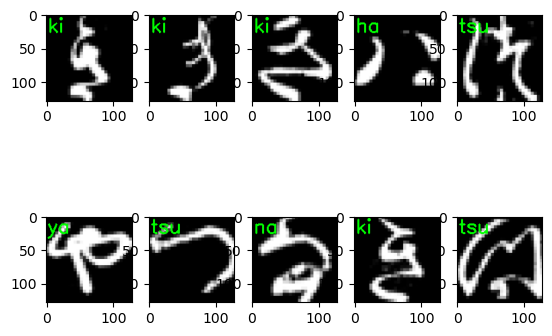

In [19]:
ncols = 5
nrows = (sampleSize//ncols)+1 if sampleSize % ncols else sampleSize//ncols
fig, axes = plt.subplots(nrows, ncols)
axes = axes.reshape(ncols*nrows)

# switch off autograd
model.eval()
with torch.no_grad():
	# loop over the test set
	for ax, (image, label) in zip(axes, testDataLoader):
		# grab the original image and ground truth label
		origImage = image.numpy().squeeze(axis=(0, 1))
		gtLabel = testSubData.dataset.classes[label.numpy()[0]]
		# send the input to the device and make predictions on it
		image = image.to(DEVICE)
		pred = model(image)
		# find the class label index with the largest corresponding
		# probability
		idx = pred.argmax(axis=1).cpu().numpy()[0]
		predLabel = testSubData.dataset.classes[idx]

  		# convert the image from grayscale to RGB (so we can draw on it)
    	# and resize it (so we can more easily see it on our screen)
		origImage = np.dstack([origImage] * 3)
		origImage = imutils.resize(origImage, width=128)
		# draw the predicted class label on it
		color = (0, 255, 0) if gtLabel == predLabel else (0, 0, 255)
		cv2.putText(origImage, gtLabel, (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)
		# display the result in terminal and show the input image
		print("ground truth label: {}, predicted label: {}".format(gtLabel, predLabel))
		ax.imshow(origImage)
fig.show()